# Extract boxes with PyTorch

In [1]:
# !pip install -U toposort
# !pip uninstall -y torch
# !pip install -U http://download.pytorch.org/whl/cu80/torch-0.2.0.post3-cp36-cp36m-manylinux1_x86_64.whl

Requirement already up-to-date: toposort in /root/.pyenv/versions/3.6.0/lib/python3.6/site-packages


In [2]:
%load_ext autoreload
%autoreload 2

import os, glob, json, tqdm, pandas, pickle, rtree, gc, toposort, joblib
import matplotlib.pyplot as plt
%pylab inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from imgaug import augmenters as iaa
from imgaug import imgaug as ia
from PIL import Image

from IPython.display import display

from prepare_images_utils import *
from latex_dataset import *

Populating the interactive namespace from numpy and matplotlib


## Prepare data source

In [3]:
IN_IMG_SUFFIX = '_in.png'
OUT_JSON_SUFFIX = '_out.json'


def load_image_with_boxes(img_id):
    img = load_image_opaque(img_id + IN_IMG_SUFFIX)
    with open(img_id + OUT_JSON_SUFFIX, 'r') as f:
        boxes = json.load(f)
    return img, boxes


def prepare_img_boxes_for_nn(img, boxes, shape=(800, 400)):
    cats, just_boxes = zip(*boxes)
    cats = numpy.array(cats)
    just_boxes = numpy.array(just_boxes) * POINTS_TO_PIXELS_FACTOR
    just_boxes = just_boxes[:, [1, 0, 3, 2]] # x1, y1, x2, y2
    cropbox = numpy.array((just_boxes[:, 0].min(),
                           just_boxes[:, 1].min(),
                           just_boxes[:, 2].max(),
                           just_boxes[:, 3].max())).astype('int')

    res_in_img = Image.new('L', shape, 255)
    res_in_img.paste(img.crop(cropbox))

    just_boxes -= cropbox[[0, 1, 0, 1]]
    just_boxes = numpy.clip(just_boxes,
                            (0, 0, 0, 0),
                            (shape[0], shape[1], shape[0], shape[1]))
    boxes_area = (just_boxes[:, 2] - just_boxes[:, 0]) * (just_boxes[:, 3] - just_boxes[:, 1])
    good_boxes = numpy.where(boxes_area > 0)[0]
    return (numpy.array(res_in_img).astype('float32'),
            cats[good_boxes],
            just_boxes[good_boxes])


def filter_by_intersection(big_box, boxes_to_filter, threshold=0.97):
    return [i for i, b in enumerate(boxes_to_filter)
            if box_inter_area(big_box, b) / box_area(b) >= threshold]


def group_by_intersection(criterion_boxes, boxes_to_group, threshold=0.97):
    result = collections.defaultdict(set)
    for group_i, big_box in enumerate(criterion_boxes):
        box_idx = filter_by_intersection(big_box, boxes_to_group)
        for box_i in box_idx:
            result[box_i].add(group_i)
    return result


def get_biggest_box(boxes):
    return boxes[numpy.argmax(list(map(box_area, boxes)))]


def make_grid(boxes):
    if len(boxes) == 0:
        return []

    rindex = rtree.index.Index(interleaved=True)
    for box_i, box in enumerate(boxes):
        rindex.insert(box_i, box)

    y1s, x1s, y2s, x2s = zip(*boxes)
    min_y, min_x, max_y, max_x = min(y1s), min(x1s), max(y2s), max(x2s)

    neighborhood = []
    for box_i, box in enumerate(boxes):
        box_y1, box_x1, box_y2, box_x2 = box

        immediate_left_neigh_border = max((boxes[i][1] for i in
                                           rindex.intersection((box_y1, min_x-1e-3, box_y2, box_x1-1e-3))),
                                          default=min_x)
        immediate_right_neigh_border = min((boxes[i][3] for i in
                                            rindex.intersection((box_y1, box_x2+1e-3, box_y2, max_x+1e-3))),
                                           default=max_x)
        immediate_upper_neigh_border = max((boxes[i][0] for i in
                                            rindex.intersection((min_y-1e-3, box_x1, box_y1-1e-3, box_x2))),
                                           default=min_y)
        immediate_lower_neigh_border = min((boxes[i][2] for i in
                                            rindex.intersection((box_y2+1e-3, box_x1, max_y+1e-3, box_x2))),
                                           default=max_y)

        cur_box_neighborhood = {}

        cur_box_neighborhood['lower'] = list(rindex.intersection((box_y2+1e-3,
                                                                  immediate_left_neigh_border,
                                                                  immediate_lower_neigh_border+1e-3,
                                                                  immediate_right_neigh_border)))

        cur_box_neighborhood['right'] = list(rindex.intersection((immediate_upper_neigh_border,
                                                                  box_x2+1e-3,
                                                                  immediate_lower_neigh_border,
                                                                  immediate_right_neigh_border+1e-3)))

        neighborhood.append(cur_box_neighborhood)
    return neighborhood


def get_axis_inter(a, b, axis):
    return max(a[axis], b[axis]), min(a[axis+2], b[axis+2])


def get_interbox_space_overlapping(a, b):
    ay1, ax1, ay2, ax2 = a
    by1, bx1, by2, bx2 = b
    iy1, iy2 = get_axis_inter(a, b, 0)
    ix1, ix2 = get_axis_inter(a, b, 1)
    if iy1 <= iy2: # intersect vertically
        if ax2 < bx1: # a is to the left of b
            return (iy1, ax2, iy2, bx1)
        else: # b is to the right a
            return (iy1, bx2, iy2, ax1)
    elif ix1 <= ix2: # intersect horizontally
        if ay2 < by1: # a is upper than b
            return (ay2, ix1, by1, ix2)
        else:
            return (by2, ix1, ay1, ix2)
    else:
        print(a, b)
        print(iy1, iy2)
        print(ix1, ix2)
        raise Exception('WAT?!?!? we must not have got here!')


def just_box_union(boxes):
    y1s, x1s, y2s, x2s = zip(*boxes)
    return [min(y1s), min(x1s), max(y2s), max(x2s)]


def get_interbox_space_fuzzy(a, b):
    return just_box_union((a, b))


def make_bi_slope(width):
    even = width % 2 == 0
    slope = numpy.arange(1, 0, -2 / width)[::-1][-width//2:]
    return numpy.concatenate([(slope if even else slope[:-1]), slope[::-1]])


def make_diagonal_mask(box, is_left):
    y1, x1, y2, x2 = box
    width = x2 - x1
    height = y2 - y1
    if height > width:
        width, height = height, width
        transposed = True
    else:
        transposed = False
    x_steps = numpy.round(width / float(height) * numpy.arange(0, height, 1)).astype('int')
    line_filler = numpy.arange(1, 0, -1 / width)[:width]
    rows = ([line_filler] + 
        [numpy.concatenate([line_filler[1:x+1][::-1], line_filler[:-x]])
         for x in x_steps[1:]])
    result = numpy.array(rows)
    if transposed:
        result = result.T
    if is_left:
        result = result[:, ::-1]
    return result


def get_interbox_mask_direction(a, b):
    ay1, ax1, ay2, ax2 = a
    by1, bx1, by2, bx2 = b
    return (ay1 - by1) * (ax1 - bx1) < 0


def make_fill_const(box, value=1):
    return value


def bbox_center_cv2(box):
    y1, x1, y2, x2 = box
    return (int((x2 + x1) / 2), int((y2 + y1) / 2))


MIN_THICKNESS = 6
MAX_THICKNESS = 40
def calc_intercell_line_mask_params(cell1, cell2, direction):
    center1 = bbox_center_cv2(cell1)
    center2 = bbox_center_cv2(cell2)
    if direction in ('same_row', 'right'):
        thickness = min(cell1[2] - cell1[0],
                        cell2[2] - cell2[0])
    elif direction in ('same_col', 'lower'):
        thickness = min(cell1[3] - cell1[1],
                        cell2[3] - cell2[1])
    else:
        raise Exception('We must not get here! {}'.format(direction))
    thickness = int(max(MIN_THICKNESS,
                        min(thickness * 0.7,
                            scipy.spatial.distance.euclidean(center1, center2),
                            MAX_THICKNESS)))
    return center1, center2, thickness


def get_intercell_line_bbox(cell1, cell2, direction):
#     (c1x, c1y), (c2x, c2y), thickness = calc_intercell_line_mask_params(cell1, cell2, direction)
#     return min(c1y, c2y), min(c1x, c2x), max(c1y, c2y), max(c1x, c2x)
    return just_box_union([cell1, cell2])


def draw_intercell_mask(output, cell1, cell2, direction, value=1.0):
    center1, center2, thickness = calc_intercell_line_mask_params(cell1, cell2, direction)
    cv2.line(output, center1, center2, (value,),
             thickness=thickness, lineType=cv2.LINE_AA)


MASK_CHANNELS = ['body', 'cell', 'same_row_other_col', 'same_col_other_row']
TOTAL_CLASSES = len(MASK_CHANNELS)
INTERCELL_LINE_WIDTH = 10
def make_mask_for_nn_intracell(size, box_cats, boxes_on_image):
    result = numpy.zeros((TOTAL_CLASSES, ) + size, dtype='float32')

    boxes_by_cat = collections.defaultdict(list)
    for cat, bbox in zip(box_cats, boxes_on_image.bounding_boxes):
        boxes_by_cat[cat].append((bbox.y1, bbox.x1, bbox.y2, bbox.x2))

    if len(boxes_by_cat[1]) == 0:
        return result

    body = get_biggest_box(boxes_by_cat[1])
    cells = boxes_by_cat[2]
    rows = boxes_by_cat[3]
    cols = boxes_by_cat[4]

    cell2rows = group_by_intersection(rows, cells)
    cell2cols = group_by_intersection(cols, cells)

    boxes_by_channel = [[body], cells]
    
    for channel, boxes in enumerate(boxes_by_channel):
        for box in boxes:
            y1, x1, y2, x2 = (int(math.floor(box[0])),
                              int(math.floor(box[1])),
                              int(math.ceil(box[2])),
                              int(math.ceil(box[3])))
            result[channel, y1:y2, x1:x2] = 1

    grid = make_grid(cells)
    for i, cur_box in enumerate(cells):
        cur_rows = cell2rows[i]
        cur_cols = cell2cols[i]
        for direction, neigh_boxes_idx in grid[i].items():
            for neigh_box_i in neigh_boxes_idx:
                neigh_box = cells[neigh_box_i]
                # here we assume that we are going to the right and bottom
                same_rows = cur_rows <= cell2rows[neigh_box_i]
                same_cols = cur_cols <= cell2cols[neigh_box_i]
                if same_rows and same_cols:
#                     print('same_rows and same_cols')
#                     print(i, neigh_box_i)
#                     print(cur_box, cells[neigh_box_i])
#                     print(cur_rows, cur_cols)
#                     print(cell2rows[neigh_box_i], cell2cols[neigh_box_i])
#                     continue
                    raise Exception('Different cells but same row and col?!?!?!?!?!')
                if not (same_rows or same_cols):
                    continue
                channel = 2 if same_rows else 3
                draw_intercell_mask(result[channel],
                                    cur_box,
                                    neigh_box,
                                    'same_row' if same_rows else 'same_col',
                                    1)

    return result


MASK_COLORS = numpy.array([
    [255,   0,   0],
    [  0, 255,   0],
    [  0,   0, 255],
    [255, 255,   0],
    [255,   0, 255],
])
def mask_to_img(mask, color_offset=0, fixed_norm=True):
    norm = float(mask.shape[0]) if fixed_norm else numpy.expand_dims(mask.sum(0), -1)
    colored = numpy.tensordot(mask, MASK_COLORS[color_offset:color_offset+mask.shape[0]], (0, 0))
    avg = numpy.nan_to_num(colored / norm)
    return avg / 255.0


def calc_loss_weights(mask, channels=None, edge_add_weight=0.2, laplacian_ksize=9, edge_th=1.1):
    result = numpy.ones_like(mask)
    if channels is None:
        channels = list(range(mask.shape[1]))
    for sample_i in range(mask.shape[0]):
        for channel_i in channels:
            edges = numpy.absolute(cv2.Laplacian(mask[sample_i, channel_i],
                                                 cv2.CV_32F,
                                                 ksize=laplacian_ksize))
            edges = numpy.where(edges > edge_th, 1, 0)
            if edges.max() > 0:
                result[sample_i, channel_i] += edge_add_weight * edges
    return result


def my_augment_bounding_boxes(augmenter, bounding_boxes_on_images, boxes_cats_by_image):
    kps_ois = []
    for bbs_oi in bounding_boxes_on_images:
        kps = []
        for bb in bbs_oi.bounding_boxes:
            kps.extend(bb.to_keypoints())
        kps_ois.append(ia.KeypointsOnImage(kps, shape=bbs_oi.shape))

    kps_ois_aug = augmenter.augment_keypoints(kps_ois)

    result = []
    for img_idx, kps_oi_aug in enumerate(kps_ois_aug):
        img_cats = boxes_cats_by_image[img_idx]
        bbs_aug = []
        aug_cats = []
        for i in range(len(kps_oi_aug.keypoints) // 4):
            bb_kps = kps_oi_aug.keypoints[i*4:i*4+4]
            x1 = numpy.clip(min([kp.x for kp in bb_kps]), 0, None)
            x2 = numpy.clip(max([kp.x for kp in bb_kps]), 0, None)
            y1 = numpy.clip(min([kp.y for kp in bb_kps]), 0, None)
            y2 = numpy.clip(max([kp.y for kp in bb_kps]), 0, None)
            area = (x2 - x1) * (y2 - y1)
            if area > 0 and x1 >= 0 and y1 >= 0:
                bbs_aug.append(
                    bounding_boxes_on_images[img_idx].bounding_boxes[i].copy(
                        x1=x1,
                        y1=y1,
                        x2=x2,
                        y2=y2
                    )
                )
                aug_cats.append(img_cats[i])
        result.append((ia.BoundingBoxesOnImage(bbs_aug,
                                               shape=kps_oi_aug.shape),
                       aug_cats))
    return result


def prepare_batch(batch_image_ids, augmenter):
    images, box_cats, boxes = zip(*[prepare_img_boxes_for_nn(*load_image_with_boxes(img_id))
                                    for img_id in batch_image_ids])

    det = augmenter.to_deterministic() if not augmenter.deterministic else augseq

    images_aug = det.augment_images(numpy.array(images).astype('uint8')).astype('float32') / 255

    boxes = [ia.BoundingBoxesOnImage([ia.BoundingBox(*box)
                                      for box in img_boxes],
                                     img.shape)
             for img, img_boxes in zip(images, boxes)]
    boxes_aug_with_cats = my_augment_bounding_boxes(det, boxes, box_cats)

    mask = numpy.array([make_mask_for_nn_intracell(img.shape, img_box_cats, img_boxes)
                        for img_name, img, (img_boxes, img_box_cats)
                        in zip(batch_image_ids, images_aug, boxes_aug_with_cats)])

    boxes_aug_lists_with_cats = []
    for img_boxes, img_box_cats in boxes_aug_with_cats:
        img_boxes_with_cats = collections.defaultdict(list)
        for b, c in zip(img_boxes.bounding_boxes, img_box_cats):
            img_boxes_with_cats[c-1].append((b.y1, b.x1, b.y2, b.x2)) # we throw away 0 category
        boxes_aug_lists_with_cats.append(img_boxes_with_cats)

    return (batch_image_ids,
            numpy.expand_dims(numpy.array(images_aug), 1),
            mask,
            calc_loss_weights(mask, channels=[1]),
            boxes_aug_lists_with_cats)


def data_gen(image_ids, augmenter, batch_size=32):
    while True:
        yield prepare_batch(numpy.random.choice(image_ids, size=batch_size),
                            augmenter)


class SegmDataset(Dataset):
    def __init__(self, all_image_ids, augmenter):
        self.all_image_ids = all_image_ids
        self.augmenter = augmenter

    def __len__(self):
        return len(self.all_image_ids)

    def __getitem__(self, i):
        (batch_image_ids,
         in_img,
         mask,
         loss_weights,
         boxes_aug) = prepare_batch([self.all_image_ids[i]],
                                    self.augmenter)
        boxes_aug_str = pickle.dumps(boxes_aug[0])
        return (batch_image_ids,
                in_img[0],
                mask[0],
                loss_weights[0],
                boxes_aug_str)


def check_image_functor(img, augmenter):
    try:
        prepare_batch([img], augmenter)
        return True, img
    except:
        return False, img


def leave_only_valid_samples(image_ids, augmenter, n_jobs=-1):
    valid = []
    errors = []
    for is_valid, img in joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(check_image_functor)(img, augmenter)
                                                        for img in image_ids):
        if is_valid:
            valid.append(img)
        else:
            errors.append(img)
    return valid, errors


imgaug_pipeline = iaa.Sequential([
#     iaa.Fliplr(0.5),
#     iaa.Flipud(0.5),
#     iaa.Affine(rotate=iap.DiscreteUniform(0, 3) * 90, cval=(0, 0, 255)),
    iaa.GaussianBlur(sigma=(0.0, 2.0)),
#     iaa.CropAndPad(px=20, pad_cval=255),
#     iaa.CropAndPad(percent=(-0.20, 0.20), pad_cval=255),
])

fake_imgaug_pipeline = iaa.Sequential([])

### Table detection

In [4]:
DET_SRC_DIR = './data/arxiv/inout_pairs/'
all_det_image_ids = [fname[:-9]
                     for fname in glob.glob(os.path.join(DET_SRC_DIR, '*_out.json'))]
random.shuffle(all_det_image_ids)

In [5]:
all_det_image_ids, strange_det_images = leave_only_valid_samples(all_det_image_ids, fake_imgaug_pipeline)
TOTAL_DET_SAMPLES = len(all_det_image_ids)
TRAIN_DET_SAMPLES = int(TOTAL_DET_SAMPLES * 0.8)
VAL_DET_SAMPLES = TOTAL_DET_SAMPLES - TRAIN_DET_SAMPLES
train_det_image_ids = all_det_image_ids[:TRAIN_DET_SAMPLES]
val_det_image_ids = all_det_image_ids[TRAIN_DET_SAMPLES:]

### Internal table structure segmentation

In [6]:
INT_SRC_DIR = './data/generated/complex_clean/src/'
all_int_image_ids = [fname[:-9]
                     for fname in glob.glob(os.path.join(INT_SRC_DIR, '*_out.json'))]
random.shuffle(all_int_image_ids)
len(all_int_image_ids)

3000

In [7]:
all_int_image_ids, strange_int_images = leave_only_valid_samples(all_int_image_ids, fake_imgaug_pipeline)
print(len(all_int_image_ids), len(strange_int_images))
TOTAL_INT_SAMPLES = len(all_int_image_ids)
TRAIN_INT_SAMPLES = int(TOTAL_INT_SAMPLES * 0.8)
VAL_INT_SAMPLES = TOTAL_INT_SAMPLES - TRAIN_INT_SAMPLES
train_int_image_ids = all_int_image_ids[:TRAIN_INT_SAMPLES]
val_int_image_ids = all_int_image_ids[TRAIN_INT_SAMPLES:]

2980 20


### Generators playground

In [8]:
qq = prepare_batch(train_int_image_ids[:10], imgaug_pipeline)

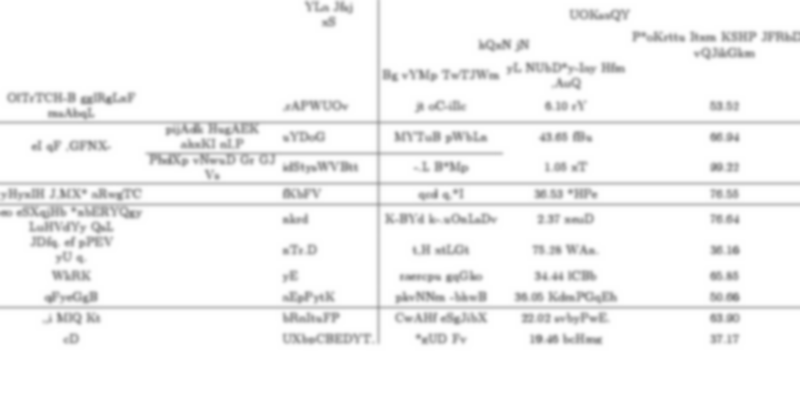

In [9]:
arr_to_img(qq[1][9][0])

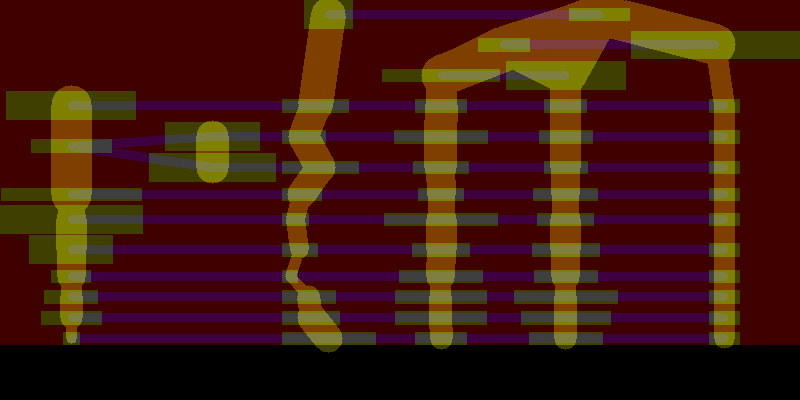

In [10]:
arr_to_img(mask_to_img(qq[2][9]))

### Compare data generators

In [11]:
# train_gen_mt = DataLoader(SegmDataset(train_image_ids, imgaug_pipeline),
#                           batch_size=8,
#                           shuffle=True,
#                           num_workers=4)
# train_gen_mt_iter = iter(train_gen_mt)
# _ = next(train_gen_mt_iter)

In [12]:
# %%prun
# for _ in range(10):
#     next(train_gen_mt_iter)

In [13]:
# train_gen_st = data_gen(train_image_ids, imgaug_pipeline, batch_size=8)
# train_gen_st_iter = iter(train_gen_st)
# _ = next(train_gen_st_iter)

In [14]:
# %%prun
# for _ in range(10):
#     next(train_gen_st_iter)

## Define losses and metrics

### Discrete

In [15]:
def get_all_boxes(mask, min_area=100, min_size=(10, 10), threshold=0.5):
# def get_all_boxes(mask, min_area=0, min_size=(0, 0), threshold=0.5):
    result = []
    contours = cv2.findContours((mask > threshold).astype('uint8'),
                                cv2.RETR_LIST,
                                cv2.CHAIN_APPROX_SIMPLE)[1]
    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        if h < min_size[0] or w < min_size[1]:
            continue
        result.append((y, x, y+h, x+w))
    result.sort()
    return result


def get_boxes_by_channel(pred):
    pred_boxes = collections.defaultdict(list)
    pred_boxes[1] = get_all_boxes(pred[1])
    pred_body = get_biggest_box(pred_boxes[1])
    for ch in range(2, TOTAL_CLASSES):
        cand_boxes = get_all_boxes(pred[ch])
        cand_idx = filter_by_intersection(pred_body, cand_boxes)
        pred_boxes[ch] = [cand_boxes[i] for i in cand_idx]
    return pred_boxes


def calc_dice(box, other):
    return 2 * box_inter_area(box, other) / (box_area(box) + box_area(other))


def calc_inter_over_other_area(box, other):
    return box_inter_area(box, other) / box_area(other)


def find_closest_box(box, others, min_overlap=0.8, calc_overlap=calc_dice):
    best_overlap = 0
    best_idx = None
    for i, other in enumerate(others):
        overlap = calc_overlap(box, other)
        if overlap > best_overlap:
            best_idx = i
            best_overlap = overlap
    return best_idx


def classify_boxes(pred_boxes, gold_boxes, strictness=0.8, calc_overlap=calc_dice):
    true_positive = []
    false_positive = []

    found_gold = set()
    pred_i_to_gold_i = {}
    for i, box in enumerate(pred_boxes):
        closest_gold_i = find_closest_box(box, gold_boxes, min_overlap=strictness, calc_overlap=calc_overlap)
        if not closest_gold_i is None:
            pred_i_to_gold_i[i] = closest_gold_i
            true_positive.append(i)
            found_gold.add(closest_gold_i)
        else:
            false_positive.append(i)

    false_negative = set(range(len(gold_boxes))) - found_gold
    return (true_positive, false_positive, false_negative, pred_i_to_gold_i)


def calc_precision(tp, fp, fn):
    denom = float(tp + fp)
    return (tp / denom) if denom > 1e-4 else 0


def calc_recall(tp, fp, fn):
    denom = float(tp + fn)
    return (tp / denom) if denom > 1e-4 else 0


def calc_metric_over_boxes(pred_boxes, gold_boxes, metric, strictness=0.8, calc_overlap=calc_dice):
    result = []
    for ch in range(len(gold_boxes)):
        tp, fp, fn, _ = classify_boxes(pred_boxes.get(ch, []),
                                       gold_boxes.get(ch, []),
                                       strictness=strictness,
                                       calc_overlap=calc_overlap)
        tp, fp, fn = len(tp), len(fp), len(fn)
        result.append(metric(tp, fp, fn))
    return result


def box_match_single_image(pred, gold_boxes, metric, strictness=0.8, calc_overlap=calc_dice):
    pred_boxes = get_boxes_by_channel(pred)
    return calc_metric_over_boxes(pred_boxes,
                                  gold_boxes,
                                  metric,
                                  strictness=strictness,
                                  calc_overlap=calc_overlap)


def box_match_batch(pred, gold_boxes, metric, strictness=0.8, calc_overlap=calc_dice):
    if not isinstance(pred, numpy.ndarray):
        pred = pred.data.cpu().numpy()
    image_metrics = [box_match_single_image(pred[i],
                                            gold_boxes[i],
                                            metric,
                                            strictness=strictness,
                                            calc_overlap=calc_overlap)
                     for i in range(pred.shape[0])]
    return numpy.array(image_metrics).mean(0)


def box_match_precision(pred, target, gold_boxes, strictness=0.95):
    return box_match_batch(pred, gold_boxes, calc_precision,
                           strictness=strictness,
                           calc_overlap=calc_dice)


def box_match_recall(pred, target, gold_boxes, strictness=0.95):
    return box_match_batch(pred, gold_boxes, calc_recall,
                           strictness=strictness,
                           calc_overlap=calc_inter_over_other_area)

# box_match_precision(numpy.tile(numpy.array([[[[1, 1, 1, 1], [1, 1, 1, 1]]]]), (1, 5, 1, 1)),
#                     None,
#                     [{2 : [[0, 0, 2, 4]]}])

### Table level

In [16]:
def flatten_cell_dependencies(grid):
    full_deps = { i : set(itertools.chain.from_iterable(neighbors.values()))
                 for i, neighbors in enumerate(grid) }
    for cell_i, neigbors in full_deps.items():
        neighs_to_remove = set()
        for neigh in neigbors:
            if cell_i in full_deps[neigh]:
                neighs_to_remove.add(neigh)
        neigbors -= neighs_to_remove
    return full_deps
        

NO_GRID = (None, (), (), (), {})
def table_grid_from_intracell_mask(mask):
    body_candidates = get_all_boxes(mask[0])
    if len(body_candidates) == 0:
        return NO_GRID
    body = get_biggest_box(body_candidates)
    cells = get_all_boxes(mask[1])
    if len(cells) == 0:
        return NO_GRID
    cells = [cells[i] for i in filter_by_intersection(body, cells)]
    grid = make_grid(cells)
    full_deps = flatten_cell_dependencies(grid)
    cell_idx = list(full_deps.keys()) # toposort.toposort_flatten(full_deps)
    intracell_relations = {}
    for cur_cell_i in cell_idx:
        cur_cell = cells[cur_cell_i]
        for direction, dir_neighbors in grid[cur_cell_i].items():
            for neigh_cell_i in dir_neighbors:
                intracell_relations[(cur_cell_i, neigh_cell_i)] = direction
    return (body, cells, grid, cell_idx, intracell_relations)


def reconstruct_table_from_grid(body, cells, grid, cell_idx, intracell_space_classes):
    cell2row = collections.defaultdict(set)
    cell2col = collections.defaultdict(set)

    for cur_cell_i in cell_idx:
        cur_cell = cells[cur_cell_i]
        lower_neighbors = grid[cur_cell_i]['lower']
        if len(lower_neighbors) == 0:
            cell2col[cur_cell_i] = { len(cell2col) }
        right_neighbors = grid[cur_cell_i]['right']
        if len(right_neighbors) == 0:
            cell2row[cur_cell_i] = { len(cell2row) }

        for neigh_cell_i in lower_neighbors + right_neighbors:
            intracell_cls_proba = intracell_space_classes[(cur_cell_i, neigh_cell_i)]
            if intracell_cls_proba[0] > 0.5:
                cell2row[cur_cell_i].update(cell2row[neigh_cell_i])
            elif intracell_cls_proba[1] > 0.5:
                cell2col[cur_cell_i].update(cell2col[neigh_cell_i])
            else:
                pass # they are not linked

    rows = collections.defaultdict(set)
    for cell_i, cell_rows_idx in cell2row.items():
        for row_i in cell_rows_idx:
            rows[row_i].add(cell_i)

    cols = collections.defaultdict(set)
    for cell_i, cell_cols_idx in cell2col.items():
        for col_i in cell_cols_idx:
            cols[col_i].add(cell_i)

    row_boxes = [just_box_union([cells[i] for i in row_idx])
                 for row_idx in rows.values()]
    row_boxes.sort(key=lambda b: b[0])

    col_boxes = [just_box_union([cells[i] for i in col_idx])
                 for col_idx in cols.values()]
    col_boxes.sort(key=lambda b: b[1])
    return (body,
            cells,
            row_boxes,
            col_boxes)


def reconstruct_table_from_intracell_mask(mask, interbox_classifier):
    body, cells, grid, cell_idx, intracell_relations = table_grid_from_intracell_mask(mask)
    intracell_space_classes = { k : interbox_classifier([mask], [pair])
                               for pair in intracell_relations }
    return reconstruct_table_from_grid(body, cells, grid, cell_idx, intracell_space_classes)


def boxes_by_channel_from_reconstructed_table(mask):
    table_info = reconstruct_table_from_intracell_mask(mask)
    if table_info is None:
        return {}
    body, cells, rows, cols = table_info
    result = { 1 : [body] }
    result[2] = cells
    result[3] = rows
    result[4] = cols
    return result


def table_level_metric_single_image(pred, gold_boxes, metric, strictness=0.5):
    pred_boxes = boxes_by_channel_from_reconstructed_table(pred)
    return calc_metric_over_boxes(pred_boxes, gold_boxes, calc_precision, strictness=strictness)


def table_level_metric_by_batch(pred, gold_boxes, metric, strictness=0.5):
    if not isinstance(pred, numpy.ndarray):
        pred = pred.data.cpu().numpy()
    image_metrics = [table_level_metric_single_image(pred[i],
                                                     gold_boxes[i],
                                                     metric,
                                                     strictness=strictness)
                     for i in range(pred.shape[0])]
    return numpy.array(image_metrics).mean(0)

def table_level_precision(pred, target, gold_boxes, strictness=0.5):
    return table_level_metric_by_batch(pred, gold_boxes, calc_precision, strictness=strictness)


def table_level_recall(pred, target, gold_boxes, strictness=0.5):
    return table_level_metric_by_batch(pred, gold_boxes, calc_recall, strictness=strictness)

### Fuzzy

$Dice(p, t, w) = 1 - \frac{ p \cdot t + 1 }{ p + t + 1 }$

$WDice(p, t, w) = 1 - \frac{ p \cdot t \cdot w^{-1} + 1 }{ p + t + p \cdot (1 - t) \cdot w + 1 }$

In [17]:
DICE_SMOOTH = 1.0
def dice_coef(pred, target, gold_boxes):
    intersection = pred * target
    union = pred + target
    return ((2. * intersection.sum(3).sum(2).sum(0) + DICE_SMOOTH) /
            (union.sum(3).sum(2).sum(0) + DICE_SMOOTH))


def px_precision(pred, target, threshold=0.5):
    pred = pred >= threshold
    target = target >= threshold
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fp = ((target - pred) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fp
    return tp / (denum + (denum == 0).float())


def px_recall(pred, target, threshold=0.5):
    pred = pred >= threshold
    target = target >= threshold
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fn = ((pred - target) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fn
    return tp / (denum + (denum == 0).float())


def make_single_channel(f, channel):
    def _impl(pred, target):
        return f(pred[:, channel:channel+1], target[:, channel:channel+1])
    return _impl


def make_cpu(f):
    def _impl(pred, target):
        return f(pred.cpu(), target.cpu())
    return _impl


TRAIN_METRICS = {'d' : (dice_coef, MASK_CHANNELS),
#                  'tp' : (table_level_precision, MASK_CHANNELS),
#                  'tr' : (table_level_recall, MASK_CHANNELS)
                }
VAL_METRICS = {'d' : (dice_coef, MASK_CHANNELS),
#                'bp' : (box_match_precision, MASK_CHANNELS),
#                'br' : (box_match_recall, MASK_CHANNELS)
#                'tp' : (table_level_precision, MASK_CHANNELS),
#                'tr' : (table_level_recall, MASK_CHANNELS),
              }

### IID Classification

In [18]:
def prepare_metric_data_by_columns(pred, target):
    pred = (pred.data.cpu().numpy() > 0.5).astype('int')
    target = (target.data.cpu().numpy() > 0.5).astype('int')
    tp = numpy.array([(pred[:, col] == target[:, col]).sum()
                      for col in range(pred.shape[1])]).astype('float32')
    fp = numpy.array([((pred[:, col] - target[:, col]) > 0).sum()
                      for col in range(pred.shape[1])]).astype('float32')
    fn = numpy.array([((target[:, col] - pred[:, col]) > 0).sum()
                      for col in range(pred.shape[1])]).astype('float32')
    return tp, fp, fn


def precision_by_col(pred, target):
    tp, fp, fn = prepare_metric_data_by_columns(pred, target)
    return numpy.nan_to_num(tp / (tp + fp))


def recall_by_col(pred, target):
    tp, fp, fn = prepare_metric_data_by_columns(pred, target)
    return numpy.nan_to_num(tp / (tp + fn))


def f1_by_col(pred, target):
    tp, fp, fn = prepare_metric_data_by_columns(pred, target)
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    return numpy.nan_to_num(2 * p * r / (p + r))


CELL_CLASSES = ('same_row', 'same_col')
CELL_TRAIN_METRICS = {'f1' : (f1_by_col, CELL_CLASSES),
                      'p' : (precision_by_col, CELL_CLASSES),
                      'r' : (recall_by_col, CELL_CLASSES) }
CELL_VAL_METRICS = {'f1' : (f1_by_col, CELL_CLASSES),
                    'p' : (precision_by_col, CELL_CLASSES),
                    'r' : (recall_by_col, CELL_CLASSES) }

### Losses

In [19]:
def dice_loss(pred, target, weights):
    intersection = pred * target
    union = pred + target
    return 1 - ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))


def weighted_dice_loss(pred, target, weights):
    # the idea is to lower actual intersection in important areas
    inv_weights = 1 / weights
    intersection = pred * inv_weights * target
    
    # the idea is to increase actual predicted values
    # where they have to be zero
    inv_target = 1 - target
    inv_intersection = pred * inv_target * weights
    union = pred + target + inv_intersection

    return 1 - ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))


def dice_bce_loss(pred, target, weights):
    return dice_loss(pred, target, weights) + F.binary_cross_entropy(pred, target, weights)

## Define a network

### Basic

In [20]:
def mcuda(x, cuda):
    return x.cuda() if cuda else x


def npten(arr, cuda):
    return mcuda(torch.from_numpy(arr), cuda)


def npvar(arr, cuda):
    if not torch.is_tensor(arr):
        arr = torch.from_numpy(arr)
    return mcuda(Variable(arr), cuda)


def is_module_on_cuda(m):
    return next(m.parameters()).is_cuda


class LocalAttention(nn.Module):
    def __init__(self, in_channels):
        super(LocalAttention, self).__init__()
        self.att = nn.Conv2d(in_channels, 1, (1, 1))

    def forward(self, x):
        unnorm = self.att(x)
        norm = F.softmax(unnorm.view(unnorm.size()[0], -1)).view(*unnorm.size())
        return x * norm


def masked_average(x, masks):
    return (x * masks).mean(3).mean(2)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilations=[1], bn=True):
        super(ConvBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        assert out_channels % len(dilations) == 0
        channels_per_dilation = out_channels // len(dilations)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels,
                                              channels_per_dilation,
                                              kernel_size,
                                              padding=dil,
                                              dilation=dil)
                                    for dil in dilations])

    def forward(self, x):
        x = self.bn(x)
        return F.relu(torch.cat([conv(x) for conv in self.convs], dim=1))

    @property
    def receptive_field(self):
        dils = numpy.array([c.dilation for c in self.convs])
        kernels = numpy.array([c.kernel_size for c in self.convs])
        kernels_odd = kernels % 2
        return (dils * (kernels - 1) + kernels_odd).max(axis=0)


class UNet(nn.Module):
    def __init__(self, out_channels=TOTAL_CLASSES, first_conv_channels=4, depth=2, out_layers=1, conv_kernel=(3, 3),
                 enc_dilations=[1], dec_dilations=[1]):
        super(UNet, self).__init__()
        self.out_channels = out_channels
        enc_channels = [1] + [first_conv_channels * (2**step) for step in range(depth)]
        self.encoder = nn.ModuleList([ConvBlock(enc_channels[i],
                                                enc_channels[i+1],
                                                conv_kernel,
                                                dilations=enc_dilations)
                                      for i in range(depth)])
        bottleneck_channels = enc_channels[-1] * 2
        self.bottleneck = ConvBlock(enc_channels[-1],
                                    bottleneck_channels,
                                    conv_kernel,
                                    dilations=enc_dilations)
        dec_channels = [bottleneck_channels] + enc_channels[:0:-1]
        self.dec_conv = nn.ModuleList([ConvBlock(dec_channels[i],
                                                 dec_channels[i+1],
                                                 conv_kernel,
                                                 dilations=dec_dilations)
                                      for i in range(depth)])
        self.dec_deconv = nn.ModuleList([nn.ConvTranspose2d(dec_channels[i],
                                                            dec_channels[i+1],
                                                            (2, 2),
                                                            stride=2)
                                         for i in range(depth)])
        self.out_layers = nn.ModuleList([ConvBlock(dec_channels[-1],
                                                   dec_channels[-1],
                                                   conv_kernel,
                                                   dilations=dec_dilations)])
        self.out_conv = nn.Conv2d(dec_channels[-1],
                                  out_channels,
                                  (1, 1))

    def forward(self, x):
        enc_conv_outs = []
        enc_pool_outs = [x]
        for enc_conv in self.encoder:
            cur_conv_out = enc_conv(enc_pool_outs[-1])
            enc_conv_outs.append(cur_conv_out)
            cur_pool_out = F.max_pool2d(cur_conv_out, (2, 2))
            enc_pool_outs.append(cur_pool_out)

        cur_out = self.bottleneck(enc_pool_outs[-1])

        for dec_step, (dec_conv, dec_deconv) in enumerate(zip(self.dec_conv, self.dec_deconv)):
            up = dec_deconv(cur_out)
            cur_out = torch.cat([up, enc_conv_outs[-dec_step-1]], dim=1)
            cur_out = dec_conv(cur_out)

        for out_layer in self.out_layers:
            cur_out = F.relu(out_layer(cur_out))

        return F.sigmoid(self.out_conv(cur_out))


class DenseNetWrapper(nn.Module):
    def __init__(self, *blocks):
        super(DenseNetWrapper, self).__init__()
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        last_out = x
        for block in self.blocks:
            last_out = block(x)
            x = torch.cat([x, last_out], 1)
        return last_out


class DenseStack(nn.Module):
    def __init__(self, *blocks):
        super(DenseStack, self).__init__()
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        outs = []
        for block in self.blocks:
            last_out = block(x)
            outs.append(last_out)
            x = torch.cat([x, last_out], 1)
        return torch.cat([t.unsqueeze(0) for t in outs]).mean(0)


class StackedUNet1(DenseStack):
    def __init__(self):
        super(StackedUNet2, self).__init__(
            UNet(first_conv_channels=6,
                 depth=4,
                 enc_dilations=[1, 2, 4, 8, 16, 32]),
            ConvBlock(TOTAL_CLASSES+1,
                      TOTAL_CLASSES,
                      (3, 3),
                      dilations=[1, 2, 4, 8, 16])
        )


def run_network(network, generator, num_batches, criterion=dice_bce_loss, optimizer=None, metrics=TRAIN_METRICS, cuda=True):
    metric_values = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        image_ids, images, mask, loss_weights, boxes = next(gen_iter)
        images_var = npvar(images, cuda)
        mask_var = npvar(mask, cuda)
        loss_weights_var = npvar(loss_weights, cuda)
        boxes = [pickle.loads(b) for b in boxes]

        cur_out = network(images_var)

        loss = criterion(cur_out, mask_var, loss_weights_var)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = { 'loss' : loss.data[0] }
        for name, (func, elem_names) in metrics.items():
            metric_value = func(cur_out, mask_var, boxes)
            if not isinstance(metric_value, (list, numpy.ndarray)):
                metric_value = metric_value.cpu().data.numpy()
            cur_metrics.update(('\n'.join((name, n)), v) for n, v in zip(elem_names, metric_value) if n)
        metric_values.append(cur_metrics)
    return metric_values

### Structured End-to-End

In [21]:
def bbox_shift(box, y, x):
    y1, x1, y2, x2 = box
    return (y1 + y, x1 + x, y2 + y, x2 + x)


class ConvFCNClassifier(nn.Module):
    def __init__(self, in_channels, out_channels, conv_layers=1, conv_kernel=(3, 3), dilations=[1, 2, 4], conv_block_class=ConvBlock):
        super(ConvFCNClassifier, self).__init__()
        conv_channels = [in_channels] + [len(dilations) * (2 ** (i + 1)) for i in range(conv_layers)]
        self.convs = nn.ModuleList([conv_block_class(conv_channels[i],
                                                     conv_channels[i+1],
                                                     conv_kernel,
                                                     dilations=dilations)
                                    for i in range(conv_layers)])
        self.attention = LocalAttention(conv_channels[-1])
        self.output = nn.Linear(conv_channels[-1], out_channels)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = self.attention(x).mean(-1).mean(-1)
        return F.sigmoid(self.output(x))

    @property
    def receptive_field(self):
        conv_fields = [c.receptive_field for c in self.convs]
        result = conv_fields[0]
        for i in range(1, len(conv_fields)):
            result += numpy.clip(conv_fields[i] // 2, 1, None)
        return result


class CellRelConvFCNClassifier(nn.Module):
    def __init__(self, base_classifier):
        super(CellRelConvAttention, self).__init__()
        self.base_classifier = base_classifier

    def forward(self, table_masks, relations_by_image):
        out = self.make_batch(table_masks, relations_by_image)
        if out is None:
            return mcuda(Variable(torch.DoubleTensor()), table_masks.data.is_cuda)
        return self.base_classifier(out)

    @staticmethod
    def make_batch(table_masks, relations_by_image):
        assert table_masks.size()[0] == len(relations_by_image)
        samples_num = sum(len(img_rels) for img_rels in relations_by_image)
        if samples_num == 0:
            return None

        rel_boxes = [get_intercell_line_bbox(cell1, cell2, direction)
                     for img_rels in relations_by_image
                     for (cell1, cell2, direction) in img_rels]
        max_rel_width = max(x2 - x1 for _, x1, _, x2 in rel_boxes) + 1
        max_rel_height = max(y2 - y1 for y1, _, y2, _ in rel_boxes) + 1

        table_masks_for_samples = npvar(numpy.zeros((len(rel_boxes),
                                                     table_masks.size()[1],
                                                     max_rel_height,
                                                     max_rel_width),
                                                    dtype='float32'),
                                        table_masks.data.is_cuda)
        relation_masks_for_samples = numpy.zeros((table_masks_for_samples.size()[0],
                                                  max_rel_height,
                                                  max_rel_width),
                                                 dtype='float32')
        sample_i = 0
        for img_i, img_rels in enumerate(relations_by_image):
            for cell1, cell2, direction in img_rels:
                by1, bx1, by2, bx2 = rel_boxes[sample_i]
                cur_table_mask = table_masks[img_i, :, by1:by2+1, bx1:bx2+1]
                mask_size = cur_table_mask.size()
                table_masks_for_samples[sample_i, :, :mask_size[1], :mask_size[2]] = cur_table_mask

                draw_intercell_mask(relation_masks_for_samples[sample_i],
                                    bbox_shift(cell1, -by1, -bx1),
                                    bbox_shift(cell2, -by1, -bx1),
                                    direction)
                sample_i += 1

        out = torch.cat([table_masks_for_samples,
                         npvar(relation_masks_for_samples, table_masks.data.is_cuda).unsqueeze(1)],
                        dim=1)
        return out


class CellRelationsClassifier(nn.Module):
    def __init__(self, base_classifier, return_grids=False):
        super(CellRelationsClassifier, self).__init__()
        self.base_classifier = base_classifier
        self.return_grids = return_grids

    def forward(self, simple_mask):
        simple_mask_np = simple_mask.data.cpu().numpy()
        grids = list(map(table_grid_from_intracell_mask, simple_mask_np))
        intracell_relation_by_image = [[(cells[i1], cells[i2], direction)
                                        for (i1, i2), direction in rels.items()]
                                       for body, cells, grid, cell_idx, rels in grids]
        intracell_classes_flat = self.base_classifier(simple_mask, intracell_relation_by_image)
        if self.return_grids:
            return intracell_classes_flat, grids
        else:
            return intracell_classes_flat


class TableSegmenter(nn.Module):
    def __init__(self):
        super(TableSegmenter, self).__init__()
        self.unet = UNet(first_conv_channels=12,
                         depth=2,
                         enc_dilations=[1, 2, 4, 8])
        self.intra_cls = CellRelationsClassifier(CellRelConvAttention(self.unet.out_channels, 2, conv_layers=1),
                                                 return_grids=True)

    def forward(self, x):
        simple_mask = self.unet(x)
        intracell_classes_flat, grids = self.intra_cls(simple_mask, intracell_relation_by_image)
        return simple_mask, grids, intracell_classes_flat


STRUCT_SAME_ROWS_I = 0
STRUCT_SAME_COLS_I = 1
def make_structured_gold_single_image(gold_boxes, grid_info, cell_strictness=0.5):
    body, pred_cells, grid, cell_idx, rels = grid_info
    gold_cells = gold_boxes[1]
    gold_rows = gold_boxes[2]
    gold_cols = gold_boxes[3]
    gold_cell2rows = group_by_intersection(gold_rows, gold_cells)
    gold_cell2cols = group_by_intersection(gold_cols, gold_cells)
    
    cell_tp, cell_fp, cell_fn, pred_cell_to_gold = classify_boxes(pred_cells,
                                                                  gold_cells,
                                                                  strictness=cell_strictness)
    gold_intracell_classes = numpy.zeros((len(rels), 2),
                                         dtype='float32')
    for row_i, (pred_i1, pred_i2) in enumerate(rels.keys()):
        gold_i1 = pred_cell_to_gold.get(pred_i1, None)
        gold_i2 = pred_cell_to_gold.get(pred_i2, None)
        if gold_i1 is None or gold_i2 is None:
            continue
        same_rows = gold_cell2rows[gold_i1] <= gold_cell2rows[gold_i2]
        if same_rows:
            gold_intracell_classes[row_i, STRUCT_SAME_ROWS_I] = 1
        same_cols = gold_cell2cols[gold_i1] <= gold_cell2cols[gold_i2]
        if same_cols:
            gold_intracell_classes[row_i, STRUCT_SAME_COLS_I] = 1
    return gold_intracell_classes


def make_structured_gold_batch(gold_boxes_by_image, grid_info_by_image, cell_strictness=0.5):
    result = [make_structured_gold_single_image(gold_boxes, grid_info)
              for gold_boxes, grid_info in zip(gold_boxes_by_image, grid_info_by_image)]
    return numpy.concatenate(result)


def run_network_structured(network, generator, num_batches,
                           raw_criterion=dice_loss, structured_criterion=F.binary_cross_entropy,
                           optimizer=None, metrics=TRAIN_METRICS, cuda=True):
    metric_values = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        image_ids, images, mask, loss_weights, boxes = next(gen_iter)
        images_var = npvar(images, cuda)
        mask_var = npvar(mask, cuda)
        loss_weights_var = npvar(loss_weights, cuda)
        boxes = [pickle.loads(b) for b in boxes]

        cur_out, pred_grids, pred_intracell_classes = network(images_var)

        raw_loss = raw_criterion(cur_out, mask_var, loss_weights_var)
        gold_intracell_classes = make_structured_gold_batch(boxes, pred_grids)
        if gold_intracell_classes.shape[0] > 0:
            gold_intracell_classes = npvar(gold_intracell_classes,
                                           pred_intracell_classes.data.is_cuda)
            structured_loss = structured_criterion(pred_intracell_classes,
                                                   gold_intracell_classes)
        else:
            structured_loss = npvar(numpy.zeros(1).astype('float32'), raw_loss.data.is_cuda)
        full_loss = raw_loss.contiguous() + structured_loss.contiguous()

        if optimizer:
            optimizer.zero_grad()
            full_loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = {'raw_loss' : raw_loss.data[0],
                       'structured_loss' : structured_loss.data[0],
                       'full_loss' : full_loss.data[0] }
        for name, (func, elem_names) in metrics.items():
            metric_value = func(cur_out, mask_var, boxes)
            if not isinstance(metric_value, (list, numpy.ndarray)):
                metric_value = metric_value.cpu().data.numpy()
            cur_metrics.update(('\n'.join((name, n)), v) for n, v in zip(elem_names, metric_value) if n)
        metric_values.append(cur_metrics)
    return metric_values

### Structured Two-step

In [22]:
def pad_and_concat(tensors):
    max_height = max(t.size()[2] for t in tensors)
    max_width = max(t.size()[3] for t in tensors)
    return torch.cat([F.pad(t, (0, max_width-t.size()[3], 0, max_height-t.size()[2]))
                      for t in tensors])


def structured_two_step_datagen(orig_datagen, model=None, cuda=True, batch_size=32, tamper_channels=[]):
    batch_input = []
    batch_output = []
    out_i = 0
    for image_ids, in_img, mask, loss_weights, boxes_aug in orig_datagen:
        if model:
            mask = model(npvar(in_img, cuda)).data
        mask = mask.cpu().numpy()
        for table_mask, gold_boxes in zip(mask, boxes_aug):
            gold_boxes = pickle.loads(gold_boxes)

            body, cells, grid, cell_idx, rels = table_grid_from_intracell_mask(table_mask)
            intracell_relation_keys = list(rels.keys())

            in_i = 0
            while in_i < len(intracell_relation_keys):
                step = min(batch_size - out_i, len(intracell_relation_keys) - in_i)

                batch_relation_keys = intracell_relation_keys[in_i:in_i+step]
                batch_relations = [(cells[i1], cells[i2], rels[(i1, i2)])
                                   for (i1, i2) in batch_relation_keys]
                batch_input.append(CellRelConvFCNClassifier.make_batch(npvar(table_mask, cuda).unsqueeze(0),
                                                                       [batch_relations]))
                gold_cls = make_structured_gold_single_image(gold_boxes,
                                                             (body, cells, grid, cell_idx,
                                                              { k : rels[k] for k in batch_relation_keys }))
                batch_output.append(npvar(gold_cls, cuda))
                in_i += step
                out_i += step

                if out_i >= batch_size:
                    out_input = pad_and_concat(batch_input)
                    if tamper_channels:
                        out_input[:, tamper_channels] = 0
                    yield out_input, torch.cat(batch_output)
                    batch_input = []
                    batch_output = []
                    out_i = 0


def run_cell_network(network, generator, num_batches, criterion=F.binary_cross_entropy, optimizer=None, metrics=CELL_TRAIN_METRICS):
    metric_values = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        inp, gold = next(gen_iter)

        pred = network(inp)

        loss = criterion(pred, gold)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = { 'loss' : loss.data[0] }
        for name, (func, elem_names) in metrics.items():
            metric_value = func(pred, gold)
            if not isinstance(metric_value, (list, numpy.ndarray)):
                metric_value = metric_value.cpu().data.numpy()
            cur_metrics.update(('\n'.join((name, n)), v) for n, v in zip(elem_names, metric_value) if n)
        metric_values.append(cur_metrics)
    return metric_values

## Train

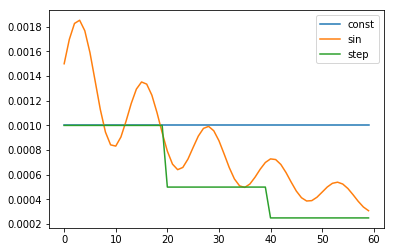

In [23]:
def clean_pytorch_dataloadergen(gen_iter):
    try:
        gen_iter._shutdown_workers()
        for _ in range(100):
            gen_iter.index_queue.put(None)
#         while not gen_iter.data_queue.empty():
#             b = gen_iter.data_queue.get()
        for w in gen_iter.workers:
            w.terminate()
        del gen_iter
    except ex:
        print(ex)


def const_lr(epoch, value=1e-3):
    return value


def step_annealed_lr(epoch, start=1e-3, step_epochs=20, decay_factor=0.5):
    lr_factor = decay_factor ** (epoch // step_epochs)
    return start * lr_factor


def sin_annealed_lr(epoch, freq=0.5, start=1e-3, sin_amp=5e-4, amp_decay_factor=0.97, mean_decay_factor=0.98, min_lr=1e-5):
    base = (numpy.sin(epoch * freq) + 1) * sin_amp * (amp_decay_factor ** epoch)
    mean = start * (mean_decay_factor ** epoch)
    return numpy.clip(base + mean, min_lr, None)


lr_vis_x = numpy.arange(0, 60, 1)
pandas.DataFrame(data=dict(const=const_lr(lr_vis_x),
                           step=step_annealed_lr(lr_vis_x),
                           sin=sin_annealed_lr(lr_vis_x))).plot()

### Run

#### Detect tables

In [24]:
# train_gen = None
# val_gen = None

# EPOCHS_NUM = 30
# BATCH_SIZE = 2
# PART_PER_EPOCH = 0.5
# BATCHES_PER_EPOCH_TRAIN = int(len(train_image_ids) * PART_PER_EPOCH // BATCH_SIZE)
# BATCHES_PER_EPOCH_VAL = int(len(val_image_ids) * PART_PER_EPOCH // BATCH_SIZE)

# net = UNet(first_conv_channels=6,
#            depth=4,
#            enc_dilations=[1, 2, 4, 8, 16, 32]).cuda()
# # LOSS = dice_bce_loss
# # LOSS = dice_loss
# LOSS = weighted_dice_loss

# LR_SCHEDULE = step_annealed_lr
# # LR_SCHEDULE = sin_annealed_lr

# print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         train_gen = iter(DataLoader(SegmDataset(train_image_ids, imgaug_pipeline),
#                                     batch_size=BATCH_SIZE,
#                                     shuffle=True,
#                                     num_workers=4))
#         val_gen = iter(DataLoader(SegmDataset(val_image_ids, imgaug_pipeline),
#                                   batch_size=BATCH_SIZE,
#                                   shuffle=True,
#                                   num_workers=2))
#         print('epoch', epoch)

#         lr = LR_SCHEDULE(epoch)
#         print('lr', lr)
#         optimizer = Adam(net.parameters(), lr=lr)

#         net.train()
#         cur_train_metrics = run_network(net, train_gen, BATCHES_PER_EPOCH_TRAIN,
#                                         criterion=LOSS,
#                                         metrics=TRAIN_METRICS,
#                                         optimizer=optimizer)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         net.eval()
#         cur_val_metrics = run_network(net, val_gen, BATCHES_PER_EPOCH_VAL,
#                                       criterion=LOSS,
#                                       metrics=VAL_METRICS)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if train_gen:
#             clean_pytorch_dataloadergen(train_gen)
#         if val_gen:
#             clean_pytorch_dataloadergen(val_gen)

#         gc.collect()

#### Segment structure

In [26]:
train_gen = None
val_gen = None

EPOCHS_NUM = 30
BATCH_SIZE = 2
PART_PER_EPOCH = 0.5
BATCHES_PER_EPOCH_TRAIN = int(len(train_int_image_ids) * PART_PER_EPOCH // BATCH_SIZE)
BATCHES_PER_EPOCH_VAL = int(len(val_int_image_ids) * PART_PER_EPOCH // BATCH_SIZE)


# net = StackedUNet1()

net = UNet(first_conv_channels=6,
           depth=4,
           enc_dilations=[1, 2, 4, 8, 16, 32]).cuda()
# LOSS = dice_bce_loss
# LOSS = dice_loss
LOSS = weighted_dice_loss

LR_SCHEDULE = step_annealed_lr
# LR_SCHEDULE = sin_annealed_lr

print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

train_metrics = []
val_metrics = []
for epoch in range(EPOCHS_NUM):
    try:
        train_gen = iter(DataLoader(SegmDataset(train_int_image_ids, imgaug_pipeline),
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=4))
        val_gen = iter(DataLoader(SegmDataset(val_int_image_ids, imgaug_pipeline),
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=2))
        print('epoch', epoch)

        lr = LR_SCHEDULE(epoch)
        print('lr', lr)
        optimizer = Adam(net.parameters(), lr=lr)

        net.train()
        cur_train_metrics = run_network(net, train_gen, BATCHES_PER_EPOCH_TRAIN,
                                        criterion=LOSS,
                                        metrics=TRAIN_METRICS,
                                        optimizer=optimizer)
        train_metrics.extend(cur_train_metrics)
        display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

        net.eval()
        cur_val_metrics = run_network(net, val_gen, BATCHES_PER_EPOCH_VAL,
                                      criterion=LOSS,
                                      metrics=VAL_METRICS)
        val_metrics.extend(cur_val_metrics)
        display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
    finally:
        if train_gen:
            clean_pytorch_dataloadergen(train_gen)
        if val_gen:
            clean_pytorch_dataloadergen(val_gen)

        gc.collect()

total parameters 135972


  0%|          | 0/596 [00:00<?, ?it/s]

epoch 0
lr 0.001


  7%|▋         | 40/596 [00:05<01:14,  7.42it/s]


KeyboardInterrupt: 

#### Structured End-to-End

In [26]:
# train_gen = None
# val_gen = None

# EPOCHS_NUM = 30
# BATCH_SIZE = 1
# PART_PER_EPOCH = 0.5
# BATCHES_PER_EPOCH_TRAIN = int(len(train_image_ids) * PART_PER_EPOCH // BATCH_SIZE)
# BATCHES_PER_EPOCH_VAL = int(len(val_image_ids) * PART_PER_EPOCH // BATCH_SIZE)

# net = TableSegmenter().cuda()
# RAW_LOSS = dice_loss
# print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         train_gen = iter(DataLoader(SegmDataset(train_image_ids, imgaug_pipeline),
#                                     batch_size=BATCH_SIZE,
#                                     shuffle=True,
#                                     num_workers=4))
#         val_gen = iter(DataLoader(SegmDataset(val_image_ids, imgaug_pipeline),
#                                   batch_size=BATCH_SIZE,
#                                   shuffle=True,
#                                   num_workers=2))
#         print('epoch', epoch)

#         lr_factor = 0.5 ** (epoch // 20)
#         lr = 1e-3 * lr_factor
#         print('lr', lr)
#         optimizer = Adam(net.parameters(), lr=lr)

#         net.train()
#         cur_train_metrics = run_network_structured(net, train_gen,
#                                                    BATCHES_PER_EPOCH_TRAIN,
#                                                    raw_criterion=RAW_LOSS,
#                                                    metrics=TRAIN_METRICS,
#                                                    optimizer=optimizer)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         net.eval()
#         cur_val_metrics = run_network_structured(net, val_gen,
#                                                  BATCHES_PER_EPOCH_VAL,
#                                                  raw_criterion=RAW_LOSS,
#                                                  metrics=VAL_METRICS)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if train_gen:
#             clean_pytorch_dataloadergen(train_gen)
#         if val_gen:
#             clean_pytorch_dataloadergen(val_gen)

#         gc.collect()

#### Structured Two-step

In [27]:
# base_segm_model = torch.load('./models/torch4_segm').cuda()

In [28]:
# base_train_gen = None
# base_val_gen = None

# EPOCHS_NUM = 60
# BASE_BATCH_SIZE = 4
# BATCH_SIZE = 10
# PART_PER_EPOCH = 0.5
# MEAN_RELS_PER_IMAGE = 2
# BATCHES_PER_EPOCH_TRAIN = int(len(train_image_ids) * PART_PER_EPOCH // BASE_BATCH_SIZE) * MEAN_RELS_PER_IMAGE
# BATCHES_PER_EPOCH_VAL = int(len(val_image_ids) * PART_PER_EPOCH // BASE_BATCH_SIZE) * MEAN_RELS_PER_IMAGE

# cell_net = ConvFCNClassifier(5, 2,
#                              conv_layers=3,
#                              dilations=[1, 2, 4, 8, 16]).cuda()
# print('receptive field', cell_net.receptive_field)
# CELL_REL_LOSS = F.binary_cross_entropy
# print('total parameters', sum(numpy.product(p.size()) for p in cell_net.parameters()))

# # cell_tamper_channels = [0, 2, 3]
# cell_tamper_channels = []

# CELL_LR_SCHEDULE = step_annealed_lr

# train_metrics = []
# val_metrics = []
# for epoch in range(EPOCHS_NUM):
#     try:
#         base_train_gen = iter(DataLoader(SegmDataset(train_image_ids, imgaug_pipeline),
#                                          batch_size=BASE_BATCH_SIZE,
#                                          shuffle=True,
#                                          num_workers=4))
#         train_gen = structured_two_step_datagen(base_train_gen,
#                                                 model=base_segm_model,
#                                                 cuda=True,
#                                                 batch_size=BATCH_SIZE,
#                                                 tamper_channels=cell_tamper_channels)
# #         qq = next(iter(train_gen))[0].data.cpu().numpy()
#         base_val_gen = iter(DataLoader(SegmDataset(val_image_ids, imgaug_pipeline),
#                                        batch_size=BASE_BATCH_SIZE,
#                                        shuffle=True,
#                                        num_workers=2))
#         val_gen = structured_two_step_datagen(base_val_gen,
#                                               model=base_segm_model,
#                                               cuda=True,
#                                               batch_size=BATCH_SIZE,
#                                               tamper_channels=cell_tamper_channels)

#         print('epoch', epoch)

#         lr = CELL_LR_SCHEDULE(epoch)
#         print('lr', lr)
#         optimizer = Adam(cell_net.parameters(), lr=lr)

#         cell_net.train()
#         cur_train_metrics = run_cell_network(cell_net, train_gen, BATCHES_PER_EPOCH_TRAIN,
#                                              criterion=CELL_REL_LOSS,
#                                              metrics=CELL_TRAIN_METRICS,
#                                              optimizer=optimizer)
#         train_metrics.extend(cur_train_metrics)
#         display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

#         cell_net.eval()
#         cur_val_metrics = run_cell_network(cell_net, val_gen, BATCHES_PER_EPOCH_VAL,
#                                            criterion=CELL_REL_LOSS,
#                                            metrics=CELL_VAL_METRICS)
#         val_metrics.extend(cur_val_metrics)
#         display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
#     finally:
#         if base_train_gen:
#             clean_pytorch_dataloadergen(base_train_gen)
#         if base_val_gen:
#             clean_pytorch_dataloadergen(base_val_gen)

#         gc.collect()

### Plot metrics

In [41]:
# train_metrics = pandas.DataFrame(train_metrics)
# val_metrics = pandas.DataFrame(val_metrics)

In [ ]:
# pandas.rolling_mean(train_metrics, 100).plot(figsize=(13, 8))

In [ ]:
# pandas.rolling_mean(val_metrics[[c for c in val_metrics.columns if 'cell' in c]], 10).plot(figsize=(13, 8))
# pandas.rolling_mean(val_metrics, 100).plot(figsize=(13, 8))

## Predict and visualize

### Table structure segmentation

In [ ]:
# torch.save(net, 'models/torch5_segm_aug')

In [44]:
# test_net = torch.load('models/torch4_segm').cuda()

In [52]:
# test_gen = DataLoader(SegmDataset(val_int_image_ids, imgaug_pipeline),
#                       batch_size=4,
#                       shuffle=True,
#                       num_workers=0)

In [63]:
# next(iter(test_gen))[1].size()

torch.Size([4, 1, 400, 800])

In [ ]:
# test_metrics = pandas.DataFrame(run_network(test_net,
#                                             test_gen,
#                                             100,
#                                             metrics=VAL_METRICS))
# test_metrics.describe().loc[['mean', 'std']]

In [ ]:
# test_batch = next(iter(test_gen))
# test_pred = test_net(npvar(test_batch[1], False))
# test_pred_np = test_pred.cpu().data.numpy()

In [ ]:
# arr_to_img(test_batch[1][5][0])

In [ ]:
# arr_to_img(mask_to_img(test_batch[2][5]))

In [ ]:
# arr_to_img(mask_to_img(test_pred_np[5]))

#### Results

torch4_segm - new dataset

	d body	d cell	d same_col_other_row	d same_row_other_col	loss
    mean	0.998203	0.949023	0.882075	0.911857	0.370951
    std	0.001029	0.005394	0.022474	0.015409	0.082468

torch3_segm_sin_lr

    d body	d cell	d same_col_other_row	d same_row_other_col	loss
    mean	0.998410	0.939392	0.841485	0.896262	0.492761
    std	0.001119	0.010956	0.029930	0.017465	0.101767

torch3_segm

	d body	d cell	d same_col_other_row	d same_row_other_col	loss
    mean	0.998310	0.940712	0.845252	0.895659	0.410746
    std	0.001132	0.009477	0.034629	0.021674	0.098735

torch2_segm

	d body	d cell	d same_col_other_row	d same_row_other_col	loss
    mean	0.989956	0.936836	0.808210	0.791179	0.495952
    std	0.006291	0.012705	0.031203	0.047960	0.125360

torch1_segm

	d body	d cell	d same_col_other_row	d same_row_other_col	loss
    mean	0.983077	0.887751	0.754271	0.692168	0.886143
    std	0.008379	0.019005	0.037087	0.053706	0.172175    

### Intracell classification

In [ ]:
# torch.save(cell_net, './models/torch4_cell')

In [42]:
cell_test_net = torch.load('models/torch4_cell').cuda()
cell_test_base_segm_model = torch.load('models/torch4_segm').cuda()

In [43]:
cell_test_gen = structured_two_step_datagen(DataLoader(SegmDataset(val_int_image_ids, imgaug_pipeline),
                                                                   batch_size=4,
                                                                   shuffle=True,
                                                                   num_workers=0),
                                                       model=cell_test_base_segm_model,
                                                       cuda=True,
                                                       batch_size=10, 
                                                       tamper_channels=[])

In [33]:
# cell_test_metrics = pandas.DataFrame(run_cell_network(cell_test_net,
#                                                       cell_test_gen,
#                                                       1000,
#                                                       metrics=CELL_TRAIN_METRICS))
# cell_test_metrics.describe().loc[['mean', 'std']]

In [34]:
# cell_test_batch = next(iter(cell_test_gen))

# cell_test_pred = cell_test_net(cell_test_batch[0])
# cell_test_pred_np = cell_test_pred.cpu().data.numpy()

# cell_test_in_np = cell_test_batch[0].data.cpu().numpy()
# cell_test_gold_np = cell_test_batch[1].data.cpu().numpy()

In [35]:
# cell_test_cls = 0
# cell_err_idx = numpy.where((cell_test_pred_np[:, cell_test_cls] > 0.5) ^ (cell_test_gold_np[:, cell_test_cls] > 0.5))[0]
# cell_err_idx

In [36]:
# arr_to_img(mask_to_img(cell_test_in_np[9]))

#### Results

##### model4 + dirty mask

	f1 same_col	f1 same_row	loss	p same_col	p same_row	r same_col	r same_row
    mean	0.989180	0.994971	0.080180	0.993083	0.996313	0.986683	0.994222
    std	0.032286	0.019886	0.105167	0.029898	0.020164	0.046321	0.028774


##### model3 + dirty mask

full

    f1 same_col	f1 same_row	loss	p same_col	p same_row	r same_col	r same_row
    count	1000.000000	1000.000000	1.000000e+03	1000.000000	1000.000000	1000.000000	1000.000000
    mean	0.983340	0.988110	1.038302e-01	0.979040	0.987869	0.990500	0.989878
    std	0.045322	0.028977	1.255031e-01	0.062619	0.037985	0.037310	0.037401

prior

	f1 same_col	f1 same_row	loss	p same_col	p same_row	r same_col	r same_row
    mean	0.386867	0.884495	0.638011	0.248800	1.0	0.969000	0.79920
    std	0.137623	0.067207	0.042811	0.106536	0.0	0.173404	0.10493

only direction mask

    f1 same_col	f1 same_row	loss	p same_col	p same_row	r same_col	r same_row
    mean	0.905572	0.960554	0.486082	0.990928	0.986694	0.841598	0.942228
    std	0.070566	0.058119	0.173850	0.049021	0.041546	0.105471	0.094352

direction + cells

    f1 same_col	f1 same_row	loss	p same_col	p same_row	r same_col	r same_row
    mean	0.949917	0.891511	0.42503	0.993760	0.839289	0.915792	0.975691
    std	0.059940	0.100130	0.13056	0.031078	0.157273	0.096916	0.060573

##### model3 + gold mask

full

	f1 same_col	f1 same_row	loss	p same_col	p same_row	r same_col	r same_row
    mean	0.992398	0.992491	0.053234	0.994786	0.987378	0.991086	0.999375
    std	0.026123	0.033263	0.102939	0.023926	0.051505	0.038615	0.008081

prior

	f1 same_col	f1 same_row	loss	p same_col	p same_row	r same_col	r same_row
    mean	0.849597	0.306073	1.079524	1.0	0.187300	0.743900	0.959000
    std	0.064837	0.125518	0.213037	0.0	0.089982	0.095979	0.198389

only direction mask

    f1 same_col	f1 same_row	loss	p same_col	p same_row	r same_col	r same_row
    mean	0.963674	0.935180	0.302549	0.975923	0.929769	0.956293	0.959424
    std	0.054372	0.110912	0.334999	0.049396	0.141161	0.080252	0.090330

direction + cells

	f1 same_col	f1 same_row	loss	p same_col	p same_row	r same_col	r same_row
    mean	0.973938	0.957742	0.313686	0.973650	0.978729	0.978013	0.944639
    std	0.051473	0.067226	0.437475	0.058283	0.069870	0.064993	0.089269

## Playground

In [251]:
def reorder_cells(c1, c2, cells, dim):
    b1, b2 = cells[c1], cells[c2]
    coord1, coord2 = b1[dim], b2[dim]
    coord1o, coord2o = b1[dim+2], b2[dim+2]
    if coord1 < coord2:
        return c1, c2, coord2 > coord1o
    else:
        return c2, c1, coord1 > coord2o


class SeqIdGen(object):
    def __init__(self):
        self.next_id = 0

    def __call__(self):
        res = self.next_id
        self.next_id += 1
        return res


def make_equivalence_classes(neighborhood):
    cell2cls = {}
    gen_cls_id = SeqIdGen()

    refs_by_cell = { c : 0
                    for cur_cell, neighs in neighborhood.items()
                    for lst in ((cur_cell,), neighs)
                    for c in lst }
    for cur_cell, neighs in neighborhood.items():
        for oc in neighs:
            refs_by_cell[oc] += 1
    cells_with_no_refs = [c
                          for c, refs_n in refs_by_cell.items()
                          if refs_n == 0]

    for cls_seed in cells_with_no_refs:
        cur_queue = collections.deque([(cls_seed, { gen_cls_id() })])

        while len(cur_queue) > 0:
            cur_cell, cur_cls = cur_queue.popleft()
            cell2cls[cur_cell] = cur_cls

            cur_neighbors = neighborhood.get(cur_cell, [])
            many_neighbors = len(cur_neighbors) > 1
            for oc in cur_neighbors:
                oc_cls = set(cur_cls)
                if many_neighbors:
                    oc_cls.add(gen_cls_id())
                cur_queue.append((oc, oc_cls))

    return cell2cls


def reconstruct_table_from_grid(body, cells, grid, cell_idx, intracell_space_classes, prob_threshold=0.5):
    row_neighbors = collections.defaultdict(set)
    col_neighbors = collections.defaultdict(set)

    for (c1, c2), probs in intracell_space_classes.items():
        b1 = cells[c1]
        b2 = cells[c2]
        if probs[STRUCT_SAME_ROWS_I] > prob_threshold:
            rc1, rc2, do_not_overlap = reorder_cells(c1, c2, cells, 1) # ensure rc1 is in the left of rc2
            if do_not_overlap:
                row_neighbors[rc1].add(rc2)
        if probs[STRUCT_SAME_COLS_I] > prob_threshold:
            cc1, cc2, do_not_overlap = reorder_cells(c1, c2, cells, 0) # ensure cc1 is above of cc2
            if do_not_overlap:
                col_neighbors[cc1].add(cc2)

    cell2rows = make_equivalence_classes(row_neighbors)
    cell2cols = make_equivalence_classes(col_neighbors)

    rows = collections.defaultdict(set)
    for cell_i, cell_rows_idx in cell2rows.items():
        for row_i in cell_rows_idx:
            rows[row_i].add(cell_i)

    cols = collections.defaultdict(set)
    for cell_i, cell_cols_idx in cell2cols.items():
        for col_i in cell_cols_idx:
            cols[col_i].add(cell_i)

    row_boxes = [just_box_union([cells[i] for i in row_idx])
                 for row_idx in rows.values()]
    row_boxes.sort(key=lambda b: b[0])

    col_boxes = [just_box_union([cells[i] for i in col_idx])
                 for col_idx in cols.values()]
    col_boxes.sort(key=lambda b: b[1])
    return (body,
            cells,
            row_boxes,
            col_boxes)


def get_segm_mask_batch(images, segm_model, cuda=True):
    batch_segm_input = npvar(numpy.expand_dims(numpy.array([numpy.array(img).astype('float32')
                                                            for img in images]),
                                               1) / 255.0,
                             cuda)
    return segm_model(batch_segm_input).data.cpu().numpy()


def parse_tables_from_images(images, det_model, segm_model, cell_model, cuda=True, cell_batch_size=64):
    batch_segm_output = get_segm_mask_batch(images, segm_model, cuda)
    tables_by_image = []
    grids_by_image = []

    for one_segm_mask in batch_segm_output:
        cur_img_tables = []
        cur_img_grids = []

        # here should go a loop over all found bodies
        body, cells, grid, cell_idx, intracell_relations = table_grid_from_intracell_mask(one_segm_mask)
        intracell_relation_keys = list(intracell_relations.keys())
        intracell_relation_classes = {}
        for batch_start in range(0, len(intracell_relation_keys), cell_batch_size):
            batch_rel_keys = intracell_relation_keys[batch_start:batch_start+cell_batch_size]
            batch_relations = [(cells[i1], cells[i2], intracell_relations[(i1, i2)])
                               for (i1, i2) in batch_rel_keys]

            cell_img_inp = npvar(one_segm_mask, cuda).unsqueeze(0)
            cell_batch_input = CellRelConvFCNClassifier.make_batch(cell_img_inp,
                                                                   [batch_relations])
            cell_batch_output = cell_model(cell_batch_input).data.cpu().numpy()
            for rel_key, cur_cell_pair_out in zip(batch_rel_keys, cell_batch_output):
                intracell_relation_classes[rel_key] = cur_cell_pair_out
        cur_img_grids.append((body, cells, grid, cell_idx, intracell_relation_classes))
        cur_img_tables.append(reconstruct_table_from_grid(body, cells, grid, cell_idx, intracell_relation_classes))

        tables_by_image.append(cur_img_tables)
        grids_by_image.append(cur_img_grids)

    return tables_by_image, grids_by_image


def make_demo_mask_from_parsed_table(img, table_info):
    body, cells, rows, cols = table_info
    boxes = [(1, body)]
    boxes.extend((2, b) for b in cells)
    boxes.extend((3, b) for b in rows)
    boxes.extend((4, b) for b in cols)
    return make_demo_mask(img, boxes)


def make_intracell_rels_symmetric(intracell_relation_classes):
    src_keys = list(intracell_relation_classes.keys())
    sums = collections.defaultdict(lambda: numpy.zeros(2, dtype='float32'))
    norms = collections.defaultdict(float)
    for (c1, c2), probs in intracell_relation_classes.items():
        if c1 > c2:
            c1, c2 = c2, c1
        symmetric_key = (c1, c2)
        sums[symmetric_key] += probs
        norms[symmetric_key] += 1
    result = {}
    for key in src_keys:
        c1, c2 = key
        if c1 > c2:
            c1, c2 = c2, c1
        symmetric_key = (c1, c2)
        result[key] = sums[symmetric_key] / norms[symmetric_key]
    return result

In [266]:
test_img_id = val_int_image_ids[10]
test_image = load_image_opaque(test_img_id + IN_IMG_SUFFIX, mode='L').crop((0, 0, 800, 400))

In [267]:
tables_by_image, grids_by_image = parse_tables_from_images([test_image],
                                                           None,
                                                           cell_test_base_segm_model,
                                                           cell_test_net,
                                                           cuda=True,
                                                           cell_batch_size=64)

In [268]:
test_grid_ic_rels = grids_by_image[0][0][-1]
print('test_grid_ic_rels', len(test_grid_ic_rels), numpy.array(list(test_grid_ic_rels.values())).mean(0))
test_grid_ic_rels_sym = make_intracell_rels_symmetric(test_grid_ic_rels)
print('test_grid_ic_rels_sym', len(test_grid_ic_rels_sym), numpy.array(list(test_grid_ic_rels_sym.values())).mean(0))

test_grid_ic_rels 226 [ 0.24455899  0.25907114]
test_grid_ic_rels_sym 226 [ 0.24455896  0.25907114]


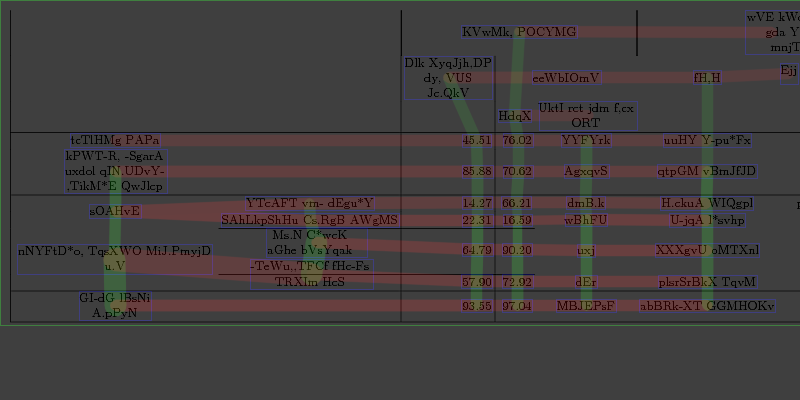

In [269]:
def make_demo_mask_from_grid_info(img, grid_info, min_prob=0.5, cells_of_interest=None, print_probs=False):
    body, cells, grid, cell_idx, intracell_relation_classes = grid_info
    rel_mask = numpy.zeros((3, img.size[1], img.size[0]), dtype='uint8')
    for (c1, c2), probs in intracell_relation_classes.items():
        if not cells_of_interest is None:
            if not (c1 in cells_of_interest or c2 in cells_of_interest):
                continue
        b1 = cells[c1]
        b2 = cells[c2]
        for ch_i in range(probs.shape[0]):
            if probs[ch_i] < min_prob:
                continue
            if print_probs:
                print(c1, c2, ch_i, probs[ch_i])
            draw_intercell_mask(rel_mask[ch_i],
                                b1,
                                b2,
                                'same_row',
                                value=int(probs[ch_i]*255))
    rel_mask = mask_to_img(rel_mask.astype('float32') / 255.0)

    rel_mask_img = arr_to_img(rel_mask)
    cells_for_display = cells if cells_of_interest is None else cells_of_interest
    base_mask = make_demo_mask(img, [(1, body)] + [(2, c)
                                                   for c in cells_for_display])
    return Image.blend(rel_mask_img.convert('RGB'), base_mask, 0.5)


def get_either(m, k):
    r = m.get(k, None)
    if r is None:
        r = m.get((k[1], k[0]), None)
    return r

# print(get_either(test_grid_ic_rels, (5, 14)))

make_demo_mask_from_grid_info(test_image, grids_by_image[0][0], min_prob=0.5)

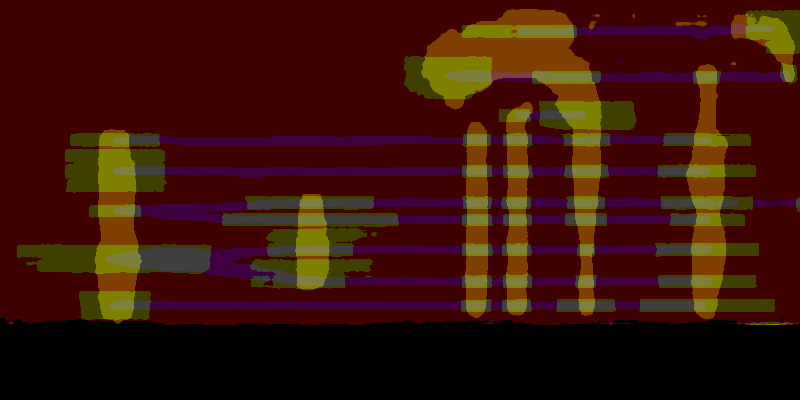

In [270]:
test_image_segm_mask = get_segm_mask_batch([test_image], cell_test_base_segm_model)
arr_to_img(mask_to_img(test_image_segm_mask[0]))

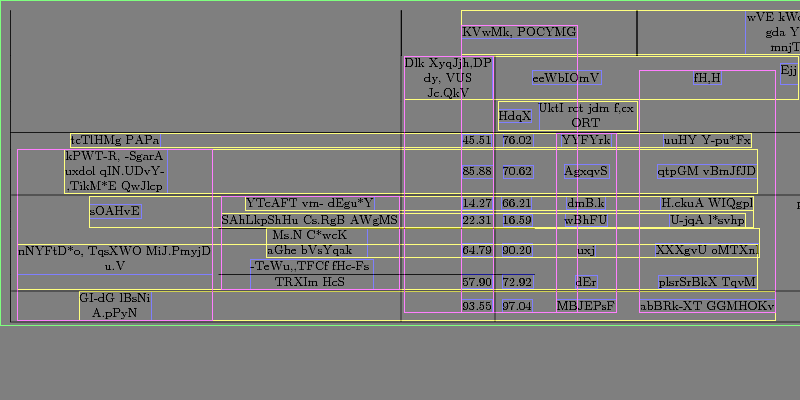

In [271]:
make_demo_mask_from_parsed_table(test_image, tables_by_image[0][0])